<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/03%20Machine%20Learning/notebooks/11-Practica-03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⭕ Práctica *final* de clasificación

Vamos a retomar el dataset de la sesión pasada (dataset PIMA). El objetivo es tener el mejor modelo posible con cada uno de los siguientes algoritmos:

* SVM
* Decision Tree
* Random Forest
* Regresión Logística

Con esto haremos una comparación entre ellos.

Los pasos a seguir son:

1. Prepara el dataset para los algoritmo, recuerda que hay algunos valores faltantes. Además, recuerda reescalar los datos apropiadamente.

2. Usando como dataset el dataset preprocesado del paso anterior, realiza una busqueda de parámetros con cada algoritmo de acuerdo a las siguientes opciones:

* SVM
 * C: 0.1,1,10,100
 * kernel: lineal, polinomial, rbf
 * grados (polinomial): 2,3,5
* Decision Tree
 * criterion: gini, entropy, log_loss
 * max_depth: None, 10, 20,
 * min_samples_split: 2, 3, 5
* Random Forest
 * criterion: gini, entropy, log_loss
 * max_depth: None, 10, 20,
 * min_samples_split: 2, 3, 5
* Regresión Logística
 * C: 0.1,1,10
 * penalty: l1, l2, elasticnet, None

3. Considerando los 4 mejores modelos anteriores. ¿Qué clasificador tiene mejor rendimiento en este dataset? Para esto toma en cuenta el accuracy en el conjunto de prueba.

In [50]:
import pandas as pd

url = 'https://github.com/DCDPUAEM/DCDP/raw/main/03%20Machine%20Learning/data/diabetes.csv'
df = pd.read_csv(url,index_col=0)
df

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [51]:
df[df['insulin']==0].shape

(374, 9)

In [52]:
df.dtypes

pregnant      int64
glucose       int64
bp            int64
skin          int64
insulin       int64
bmi         float64
pedigree    float64
age           int64
label         int64
dtype: object

 La variable insulin es la que tiene más datos faltantes: 374


Text(0.5, 1.0, 'Valores faltantes')

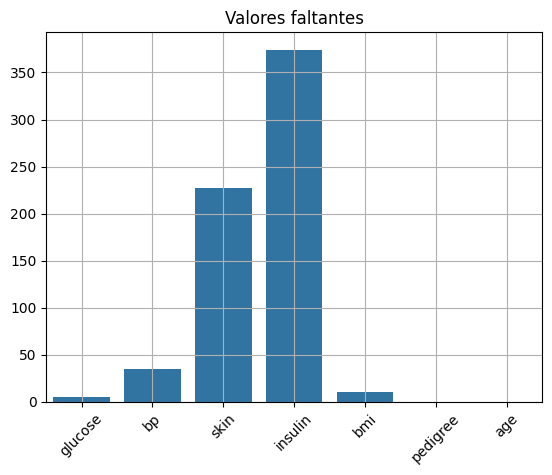

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt


faltantes_sum = (df.drop(columns=['pregnant', 'label']) == 0).sum()
print(f' La variable {faltantes_sum.idxmax()} es la que tiene más datos faltantes: {faltantes_sum.max()}')
sns.barplot(faltantes_sum)
plt.grid()
plt.xticks(rotation=45)
plt.title('Valores faltantes')

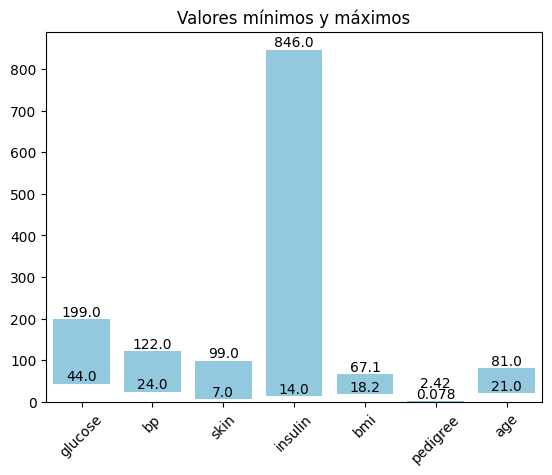

In [54]:
import numpy as np

faltantes = df.drop(columns=['pregnant', 'label']).replace(0, np.nan)

sns.barplot( faltantes.max() , color='skyblue')
sns.barplot( faltantes.min(), color='white')
plt.xticks(rotation = 45)
plt.title('Valores mínimos y máximos')
for i, valor_minimo, valor_maximo in zip(range(len(faltantes.columns)), faltantes.min(), faltantes.max()):
    x = 0
    if i == 5:
      x = 25
    plt.text(i, valor_minimo, str(valor_minimo), ha='center', va='bottom', color='black', fontsize=10)
    plt.text(i, valor_maximo + x, str(valor_maximo), ha='center', va='bottom', color='black', fontsize=10)


Como hay muchos valores faltantes, vamos a imputar valores faltantes usando el valor promedio. Esto es porque son muchos y eliminarlos podría afectar negativamente el modelo. Además, las valores de las columnas se van a normalizar con media de 0 y desviación estándar de 1. También vamos a filtar el índice de masa corporal desde 18.5 a 40.

In [56]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

def pre_process():
  url = 'https://github.com/DCDPUAEM/DCDP/raw/main/03%20Machine%20Learning/data/diabetes.csv'
  df = pd.read_csv(url,index_col=0)

  # Imputar valores faltantes
  imputer = SimpleImputer(strategy='mean')
  columns_to_impute = ['glucose', 'bp', 'skin', 'insulin', 'bmi']
  df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

  # Filtrar BMI
  df = df[(df['bmi'] >= 18.5) & (df['bmi'] <= 40)]

  X = df.drop(columns=['label'])
  y = df['label']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  return df, X, y, X_train, X_test, y_train, y_test


In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [58]:
#SVM
df, X, y, X_train, X_test, y_train, y_test = pre_process()

# aquí normalizamos los valores y seleccionamos el modelo
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

#Aquí seleccionamos los distintos hiper parametros que se sugirieron
param_grid = [
    {
        'svc__C': [0.1, 1, 10, 100],
        'svc__kernel': ['linear']
    },
    {
        'svc__C': [0.1, 1, 10, 100],
        'svc__kernel': ['poly'],
        'svc__degree': [2, 3, 5]
    },
    {
        'svc__C': [0.1, 1, 10, 100],
        'svc__kernel': ['rbf']
    }
]

# GridSearchCV con cvm con datos normalizados, con 5 folds de cross validation, n_jobs = -1 me permite usar todos los procesadores
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo
grid_search.fit(X_train, y_train)


# Reporte de clasificación

# Mejor combinación de parámetros
best_params = grid_search.best_params_
print("Mejores parámetros:", best_params)

# rendimiento promedio del modelo en el conjunto de entrenamiento durante la validación cruzada.
best_score = grid_search.best_score_
print("Mejor score:", best_score)

# best model elije al mejor modelo con los mejores parametros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Accuracy para despues comparar entre modelos
accuracy_svm = accuracy_score(y_test, y_pred)
print("SVM accuracy:", accuracy_svm)


Mejores parámetros: {'svc__C': 1, 'svc__kernel': 'linear'}
Mejor score: 0.7676190476190476
SVM accuracy: 0.803030303030303


In [59]:
# Decision Tree
df, X, y, X_train, X_test, y_train, y_test = pre_process()

pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('decisiontreeclassifier', DecisionTreeClassifier())
])

param_grid_dt = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy', 'log_loss'],
    'decisiontreeclassifier__max_depth': [None, 10, 20],
    'decisiontreeclassifier__min_samples_split': [2, 3, 5]
}

grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Reporte de clasificación
best_params_dt = grid_search_dt.best_params_
print("Mejores parámetros:", best_params_dt)

best_model_dt = grid_search_dt.best_estimator_
y_pred_dt = best_model_dt.predict(X_test)
#Accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree accuracy:", accuracy_dt)

Mejores parámetros: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_split': 5}
Decision Tree accuracy: 0.6893939393939394


In [60]:
#Random forest
df, X, y, X_train, X_test, y_train, y_test = pre_process()


pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('randomforestclassifier', RandomForestClassifier())
])

param_grid_rf = {
    'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_split': [2, 3, 5]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Reporte de clasificación
best_params_rf = grid_search_rf.best_params_
print("Mejores parámetros:", best_params_rf)

best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)
#Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest accuracy:", accuracy_rf)

Mejores parámetros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 3}
Random Forest accuracy: 0.803030303030303


In [61]:
# Regresión Logística

df, X, y, X_train, X_test, y_train, y_test = pre_process()

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('logisticregression', LogisticRegression(solver='saga', max_iter=10000))
])

param_grid_lr = {
    'logisticregression__C': [0.1, 1, 10],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet', None],
    'logisticregression__solver': ['saga']  # 'saga' es requerido para 'elasticnet'
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

# Reporte de clasificación
best_params_lr = grid_search_lr.best_params_
print("Mejores parámetros:", best_params_lr)

best_model_lr = grid_search_lr.best_estimator_
y_pred_lr = best_model_lr.predict(X_test)
#Accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Regresion logaritmica accuracy:", accuracy_lr)

Mejores parámetros: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
Regresion logaritmica accuracy: 0.8106060606060606


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbos

In [62]:
# Comparamos el accuracy de los 4 modelos

classifiers = {'SVM': accuracy_svm, 'Decision Tree': accuracy_dt, 'Random Forest': accuracy_rf,
                   'Logistic Regression': accuracy_lr}
best_classifier = max(classifiers, key = classifiers.get)

print("Mejor clasificador:", best_classifier, "con una accuracy de:", classifiers[best_classifier])


Mejor clasificador: Logistic Regression con una accuracy de: 0.8106060606060606


Hay más clasificadores que es importante revisar. Con las herramientas que ya cuentas, ya puedes revisarlos por tu cuenta:

* [K-nearest neighbors classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
* [Quadratic Discriminant Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis)
* [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)
* [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes)
* ...

[Más información](https://scikit-learn.org/stable/supervised_learning.html), [comparación](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).